In [1]:
# !pip install opencv-python
# !pip install imutilsa


In [2]:
# !pip install opencv-contrib-python


# HOG + SVM 

In [3]:
import cv2
import imutils
 
# Initializing the HOG person
# detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
 
cap = cv2.VideoCapture('data/vid.mov')
 
while cap.isOpened():
    # Reading the video stream
    ret, image = cap.read()
    if ret:
        image = imutils.resize(image, 
                               width=min(400, image.shape[1]))
 
        # Detecting all the regions 
        # in the Image that has a 
        # pedestrians inside it
        (regions, _) = hog.detectMultiScale(image,
                                            winStride=(4, 4),
                                            padding=(4, 4),
                                            scale=1.05)
 
        # Drawing the regions in the 
        # Image
        for (x, y, w, h) in regions:
            cv2.rectangle(image, (x, y),
                          (x + w, y + h), 
                          (0, 0, 255), 2)
 
        # Showing the output Image
        cv2.imshow("Image", image)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

Limitations of HOG+SVM:

Works best for upright, full-body people with clear backgrounds

Very sensitive to occlusion, pose, lighting, and scale changes

Has trouble with small, partially visible, or side-view pedestrians

Not robust for crowded or low-resolution frames

# Applying state of art pretrained YOLO11

In [8]:
import cv2
import numpy as np

# Load YOLOv4 weights and config
net = cv2.dnn.readNet("yolov4-tiny.weights", "yolov4-tiny.cfg")
layer_names = net.getLayerNames()
out_layer_idxs = net.getUnconnectedOutLayers().flatten()
output_layers = [layer_names[i - 1] for i in out_layer_idxs]

cap = cv2.VideoCapture('data/retail-store.mp4')

scale_factor = 0.5  # Change to 0.3, 0.4, etc., as needed

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    height, width = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Parse results and draw bounding boxes
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if class_id == 0 and confidence > 0.5:  # 'person' class
                center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
                x = int(center_x - w/2)
                y = int(center_y - h/2)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Resize frame for display
    display_frame = cv2.resize(frame, None, fx=scale_factor, fy=scale_factor)
    cv2.imshow("YOLO Human Detection", display_frame)
    key = cv2.waitKey(25)
    # Exit if 'q' is pressed or window is closed
    if key & 0xFF == ord('q') or cv2.getWindowProperty("YOLO Human Detection", cv2.WND_PROP_VISIBLE) < 1:
        break

cap.release()
cv2.destroyAllWindows()


Starting YOLOv4 Store Heatmap Processing...
Loading YOLOv4 network...
Retrieving output layer names...
Output layers: ['yolo_139', 'yolo_150', 'yolo_161']
Opening video source: data/retail-store.mp4
Reading first frame to get frame size...
Frame size: 1270x720
Starting frame processing loop...
Processing frame 30...
Processing frame 60...
Processing frame 90...
Processing frame 120...
Processing frame 150...
Processing frame 180...
Processing frame 210...
Processing frame 240...
Processing frame 270...
Processing frame 300...
Processing frame 330...
Processing frame 360...
Processing frame 390...
Processing frame 420...
Processing frame 450...
Processing frame 480...
Processing frame 510...
Processing frame 540...
Processing frame 570...
Processing frame 600...
Processing frame 630...
Processing frame 660...
Processing frame 690...
Processing frame 720...
Processing frame 750...
Processing frame 780...
Processing frame 810...
Processing frame 840...
Processing frame 870...
Processing f

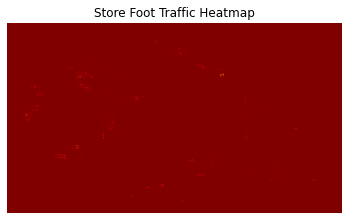

Process completed.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Starting YOLOv4 Store Heatmap Processing...")

# Load YOLOv4 network
print("Loading YOLOv4 network...")
net = cv2.dnn.readNet('yolov4.weights', 'yolov4.cfg')

# Enable GPU if available and OpenCV compiled with CUDA (optional)
# net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# Get output layer names safely (fix for OpenCV versions)
print("Retrieving output layer names...")
layer_names = net.getLayerNames()
unconnected_layers = net.getUnconnectedOutLayers()
if isinstance(unconnected_layers, np.ndarray):
    output_layers = [layer_names[i - 1] for i in unconnected_layers.flatten()]
else:
    output_layers = [layer_names[i - 1] for i in unconnected_layers]
print("Output layers:", output_layers)

# Person class ID
PERSON_CLASS_ID = 0

# Open video file or camera stream
video_path = 'data/retail-store.mp4'
print(f"Opening video source: {video_path}")
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video source.")
    exit()

# Read first frame to get size
print("Reading first frame to get frame size...")
ret, frame = cap.read()
if not ret:
    print("Error: Could not read first frame from video.")
    cap.release()
    exit()

frame_height, frame_width = frame.shape[:2]
print(f"Frame size: {frame_width}x{frame_height}")

# Create heatmap accumulator
heatmap = np.zeros((frame_height, frame_width), dtype=np.float32)

frame_count = 0

print("Starting frame processing loop...")
while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video stream or cannot fetch frame.")
        break

    frame_count += 1

    # Skip frames for faster processing (process every 3rd frame)
    if frame_count % 3 != 0:
        continue

    if frame_count % 10 == 0:
        print(f"Processing frame {frame_count}...")

    height, width = frame.shape[:2]

    # Prepare input blob with reduced size 320x320 for faster inference
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (320, 320), swapRB=True, crop=False)
    net.setInput(blob)

    # Forward pass
    outs = net.forward(output_layers)

    # Parse detections
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if class_id == PERSON_CLASS_ID and confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                heatmap[center_y, center_x] += 1

print(f"Processed total {frame_count} frames (with skipping).")
cap.release()
cv2.destroyAllWindows()

print("Normalizing and visualizing heatmap...")
# Normalize and convert heatmap for visualization
heatmap_norm = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
heatmap_uint8 = np.uint8(heatmap_norm)
colored_heatmap = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

plt.imshow(colored_heatmap)
plt.title('Store Foot Traffic Heatmap')
plt.axis('off')
plt.show()

print("Process completed.")


# Applying Yolo11 by Ultralytics

In [2]:
!pip install -U ultralytics

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
argilla 1.7.0 requires numpy<1.24.0, but you have numpy 2.0.2 which is incompatible.
pandas-profiling 3.1.0 requires joblib~=1.0.1, but you have joblib 1.4.2 which is incompatible.

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)


   ---------------------------------------- 1.0/1.0 MB 8.4 MB/s  0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.3
    Uninstalling tqdm-4.62.3:
      Successfully uninstalled tqdm-4.62.3



In [6]:
from ultralytics import YOLO

model = YOLO('yolo11n.pt')  # automatically downloads YOLO11n model

In [7]:
from ultralytics import YOLO
import cv2

# Load the YOLO11 model
model = YOLO('yolo11n.pt')

# Open the video file
cap = cv2.VideoCapture('data/vid.mov')

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # YOLOv11 expects BGR images directly from OpenCV
    results = model(frame, classes=[0])  # class 0 = 'person' in COCO

    # Draw bounding boxes for detected people
    annotated_frame = results.plot()

    cv2.imshow('YOLO 11 Human Detection', annotated_frame)
    key = cv2.waitKey(1)
    if key & 0xFF == ord('q') or cv2.getWindowProperty("YOLO 11 Human Detection", cv2.WND_PROP_VISIBLE) < 1:
        break

cap.release()
cv2.destroyAllWindows()


RuntimeError: Numpy is not available

In [5]:
!pip install --upgrade numpy

In [8]:
import numpy
print(numpy.__version__)


2.0.2
